# Sparkify Project Cluster Workspace

In [1]:
sc.install_pypi_package("sklearn", "https://pypi.org/simple")
sc.install_pypi_package("matplotlib", "https://pypi.org/simple")
sc.install_pypi_package("pandas", "https://pypi.org/simple")
sc.install_pypi_package("seaborn", "https://pypi.org/simple")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1580198714329_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Processing /mnt/var/lib/livy/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c/sklearn-0.0-py2.py3-none-any.whl
  Using cached scikit_learn-0.22.1-cp36-cp36m-manylinux1_x86_64.whl (7.0 MB)
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)
  Using cached joblib-0.14.1-py2.py3-none-any.whl (294 kB)

  Using cached matplotlib-3.1.2-cp36-cp36m-manylinux1_x86_64.whl (13.1 MB)
  Using cached pyparsing-2.4.6-py2.py3-none-any.whl (67 kB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)
  Using cached kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl (90 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

  Using cached pandas-0.25.3-cp36-cp36m-manylinux1_x86_64.whl (10.4 MB)

  Using cached seaborn-0.10.0-py3-none-any.whl (215 kB)

In [2]:
# import libraries
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F

from datetime import datetime


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
%matplot plt

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import GBTClassifier, LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from sklearn.metrics import confusion_matrix
import pandas as pd



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Create Spark session and read the sparkify dataset

In [3]:
# Create spark session
# spark = SparkSession \
#     .builder \
#     .appName("Sparkify") \
#     .getOrCreate()

# Read in full sparkify dataset
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
# event_data = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042')

Print schema to get the first impression of the data

In [4]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

Select few columns and print the distinct values to see them

In [5]:
df.select("level").distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+
|level|
+-----+
| free|
| paid|
+-----+

In [6]:
df.select("page").distinct().show(30,False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+

In [7]:
df.select("userId").distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+
| userId|
+-------+
|1331962|
|1178731|
|1528396|
|1002185|
|1333041|
|1567623|
|1190352|
|1983423|
|1271218|
|1396828|
|1142513|
|1875484|
|1083324|
|1612069|
|1734557|
|1071308|
|1492713|
|1200956|
|1396135|
|1718034|
+-------+
only showing top 20 rows

Define UDFs to check if userId is a digit to filter for empty userIds

In [8]:
@F.udf("boolean")
def is_digit(value):
    if value:
        return value.isdigit()
    else:
        return False

@F.udf("boolean")
def is_not_digit(value):
    if value:
        return not value.isdigit()
    else:
        return True


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
df = df.filter(is_digit("userId"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

sessionId is saved as long integers so I can use the isnan function from spark

In [10]:
sessionIdIsNan = df.select(F.isnan('sessionId').cast('int').alias('sessionIdIsNan'))
sessionIdIsNan.groupBy().sum().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+
|sum(sessionIdIsNan)|
+-------------------+
|                  0|
+-------------------+

There are no nan values so nothing to clear

___

Define UDF to get day in a month from event. Useful to see usage over month

In [11]:
@F.udf('int')
def get_day_of_month(value):
    return datetime.fromtimestamp(value / 1000.0).day

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
df = df.withColumn('day_of_month', get_day_of_month('ts'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Define UDF to get state out of location to chek usage differences of states

In [13]:
@F.udf('string')
def get_state(value):
    if(value):
        return value.split(', ')[1]
    else:
        return '';


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
df = df.withColumn('state',get_state('location'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

___

## Exploratoy Data Analysis

We got our first impression of the data and cleared empty or missing userIds and sessionIds.

First we will define the churn. We will search for events with the page 'Cancellation Confirmation' and add a 1 in a 'churn'-column if we find the page for the user and 0 otherwise.

In [15]:
@F.udf('int')
def cancellation_confirmation_flag(value):
    if value == "Cancellation Confirmation":
        return 1
    else:
        return 0

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
df = df.withColumn("churn_flag",cancellation_confirmation_flag('page'))

churn_window = Window.partitionBy('UserId')
df = df.withColumn("churn", F.max('churn_flag').over(churn_window))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

___

Now we can have a look at different aggregations of user which had churned and otherwise.

We reuse the pandas dataframe variable to safe memory on the main node.

We begin to have a look at the gender counts:

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

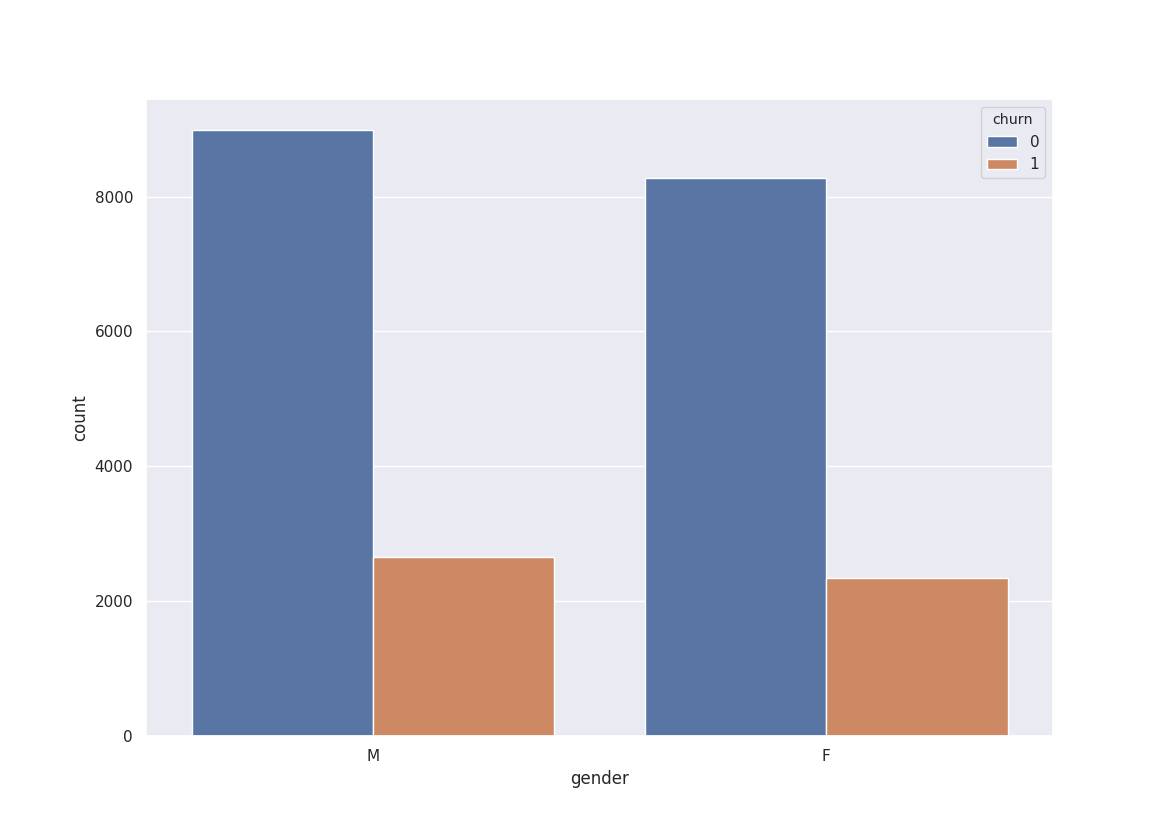

In [17]:
dfp = df.dropDuplicates(['userId','gender']).select(['userId','gender','churn']).toPandas()
plt.clf()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x = "gender", hue = "churn", data = dfp)
%matplot plt

We see that more male users churned so the gender could be an indicator.

Next we will check the Level to see a difference between free and paid users

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

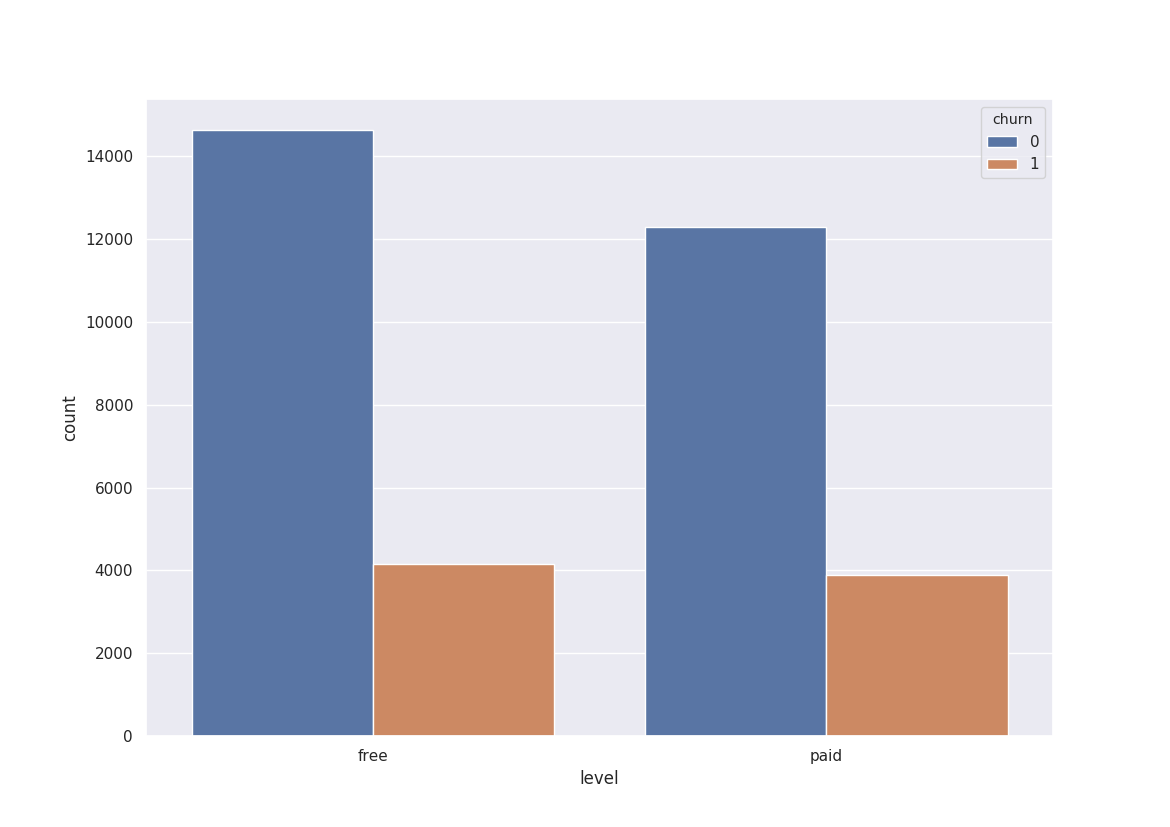

In [18]:
dfp = df.dropDuplicates(['userId','level']).select(['userId','level','churn']).toPandas()
plt.clf()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x = "level", hue = "churn", data = dfp)
%matplot plt

More free users churn so maybe these people are more unsatisfied.

Then we have look at the pages ov all events overall to see how the groups interact with sparkify

In [19]:
dfp = df.groupBy('page','churn').count().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

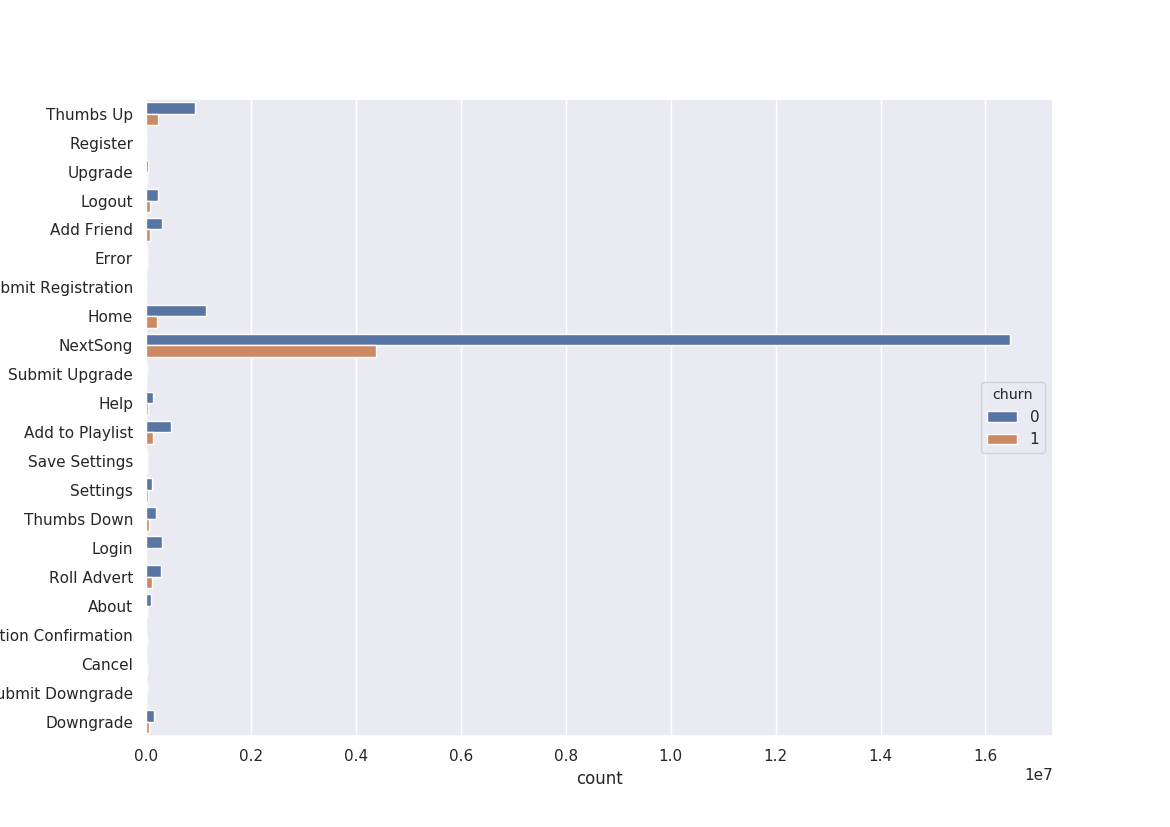

In [20]:

plt.clf()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x = "count", y="page", hue = "churn", data = dfp)
%matplot plt

Clearly the most interaction is "NextSong". I will discard it because in comparison all other events seem small, so it could be an outlier. Lets calculate the relative frequency and plot it again:

In [21]:
df_page_churn = df.filter("page != 'NextSong'").groupBy(['page','churn']).count()
total_sums = df_page_churn.groupBy('churn').sum('count').collect()
sum_churn = total_sums[0][1]
sum_not_churn = total_sums[1][1]

dfp = df_page_churn.withColumn('relativeFrequency',F.when(df_page_churn['churn']==0,df_page_churn['count']/sum_not_churn).otherwise(df_page_churn['count']/sum_churn)).toPandas()



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

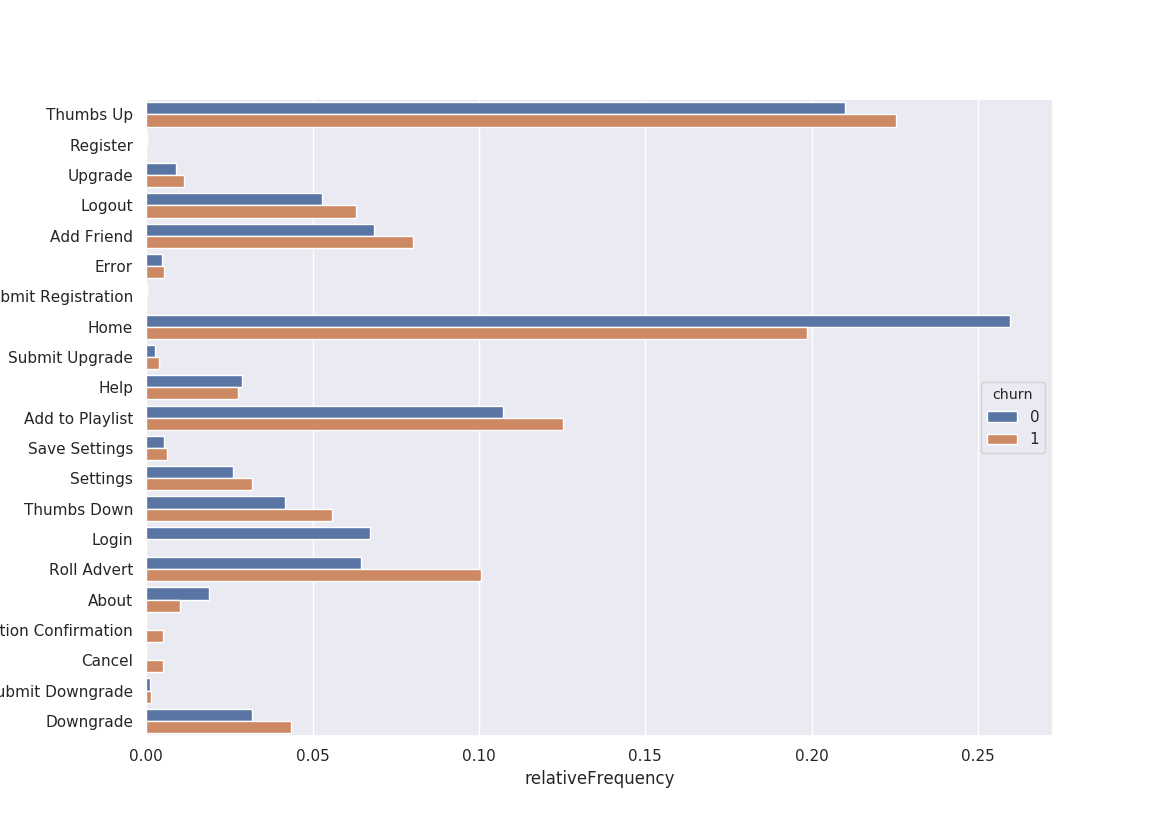

In [22]:
plt.clf()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x = "relativeFrequency", y="page", hue = "churn", data = dfp)
%matplot plt

People who have churned got more 'Roll Advert','Thumbs Down','Error','Logout' and 'Downgrade' pages. So these could be could indicators for churn.

The other group used more the 'Home' page. So this could mean a more frequent usage of the service.

In the next steps lets have a look at occurences per session.
We begin with events per session:

I will define a function to plot boxplots beforehand

In [23]:
def plot_boxplot(column,dataframe):
    plt.clf()
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.boxplot(x='churn', y=column, data=dataframe)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
df_sessionId_churn_count = df.groupBy('userId','sessionId','churn').count()
df_userId_sessionId_count = df_sessionId_churn_count.groupBy('userId','churn').mean('count').withColumnRenamed('avg(count)','events_per_session_mean')
dfp=df_userId_sessionId_count.toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

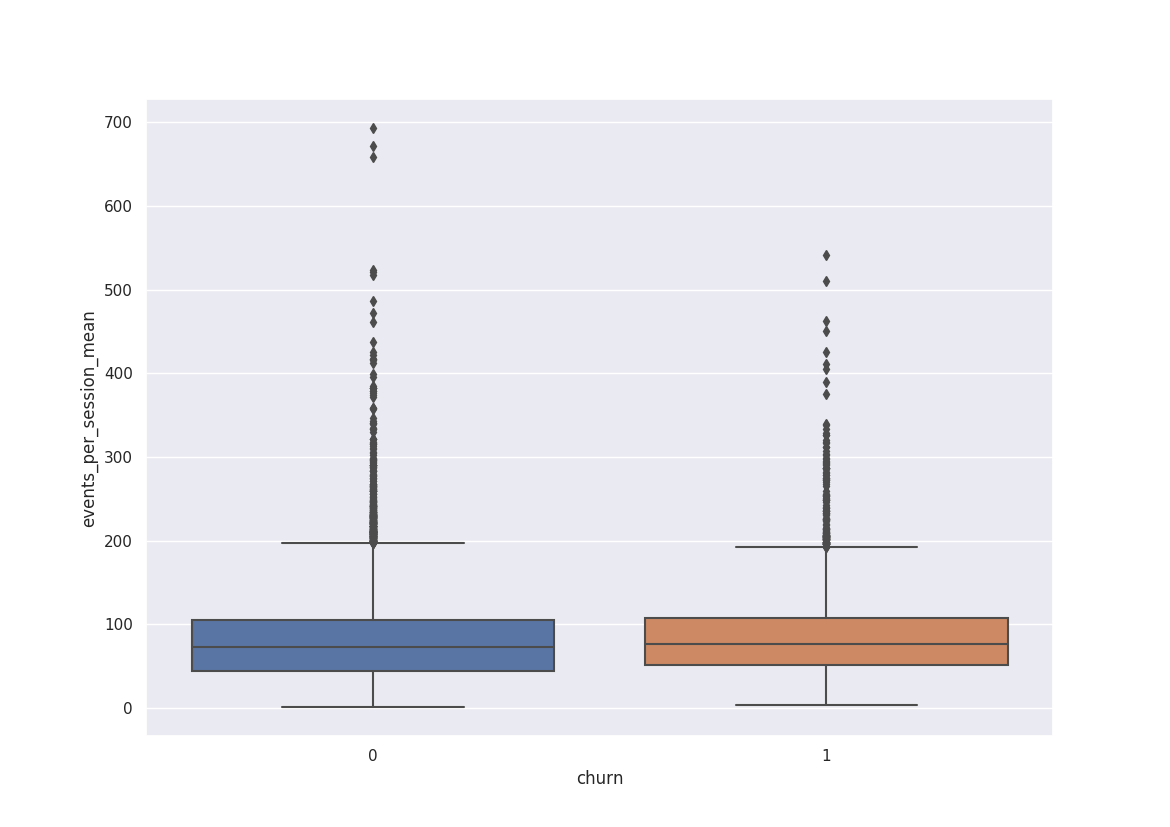

In [25]:
plot_boxplot("events_per_session_mean",dfp)
%matplot plt

Churned users seem to interact more with sparkify. So maybe they use the service more in the shorter duration until they churn.

Lets check if the same is true for the songs per session:

In [26]:
df_song_churn_count = df.groupBy('userId','sessionId','song','churn').count()
df_song_churn_count = df_song_churn_count.groupBy('userId','sessionId','churn').count()
df_song_churn = df_song_churn_count.groupBy('userId','churn').mean('count').withColumnRenamed('avg(count)','songs_per_session_mean')
dfp = df_song_churn.toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

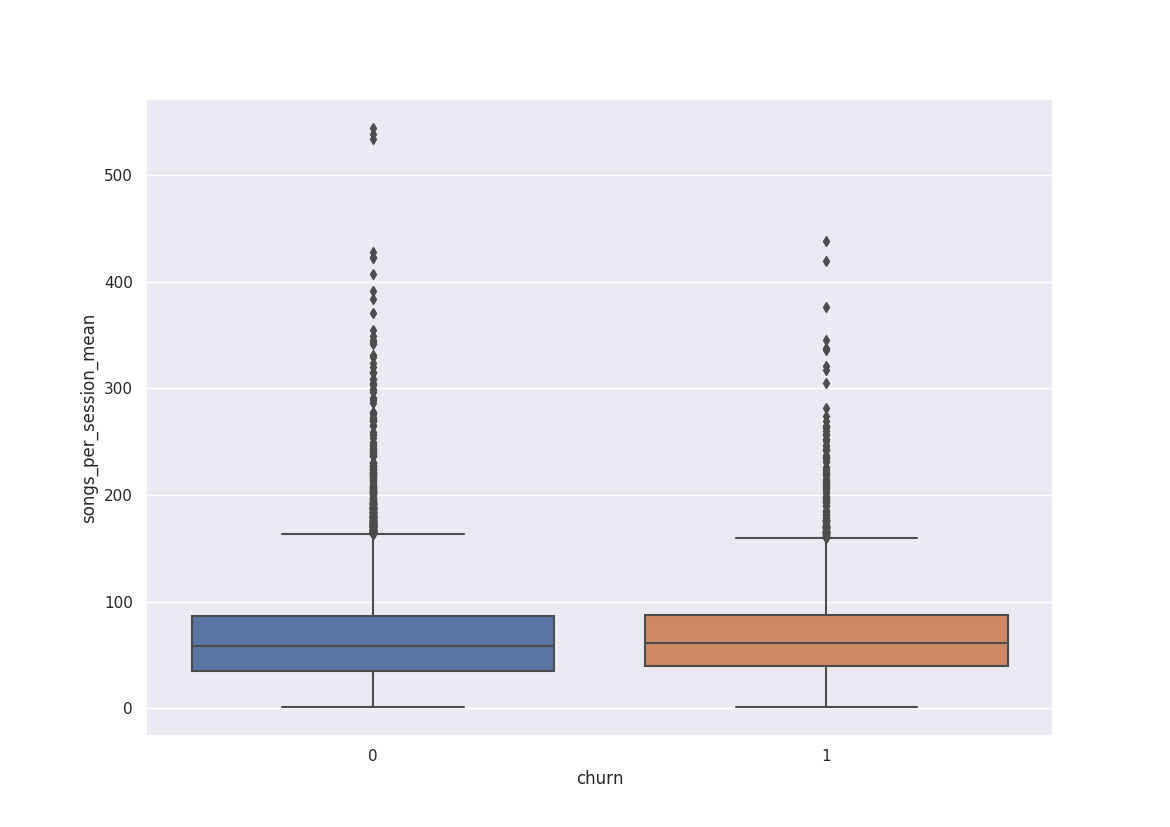

In [27]:
plot_boxplot("songs_per_session_mean",dfp)
%matplot plt

So yes churned users listen to more songs

For specific events per session we define a function

In [28]:
def boxplot_specific_event_per_session(event,columnName):
    df_aggregation = df.filter(df['page'] == event).groupBy('userId','sessionId','churn').count()
    df_aggregation_per_session = df_aggregation.groupBy('userId','churn').mean('count').withColumnRenamed('avg(count)',columnName)
    dfp = df_aggregation_per_session.toPandas()
    print(dfp.head())
    plt.clf()
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.boxplot(x='churn', y=columnName, data=dfp);
    
    return df_aggregation_per_session

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

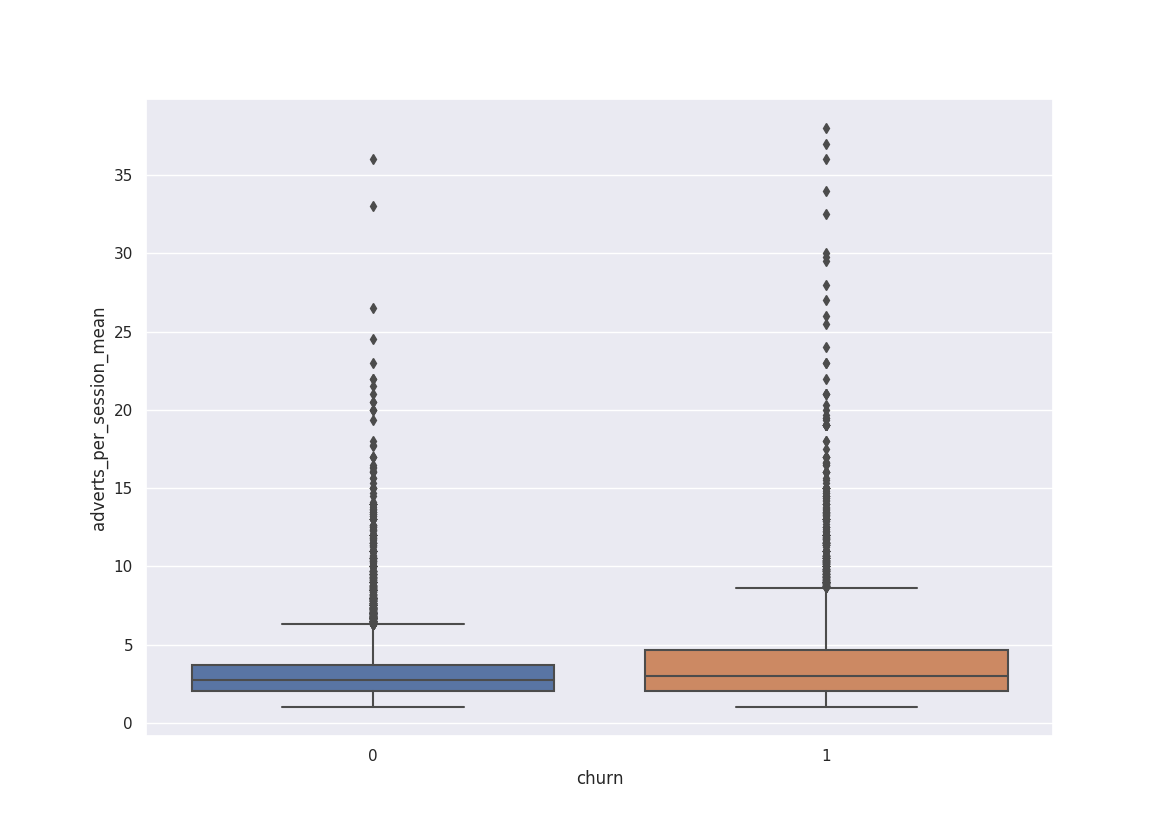

In [29]:
df_adverts_per_session_mean = boxplot_specific_event_per_session('Roll Advert','adverts_per_session_mean')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

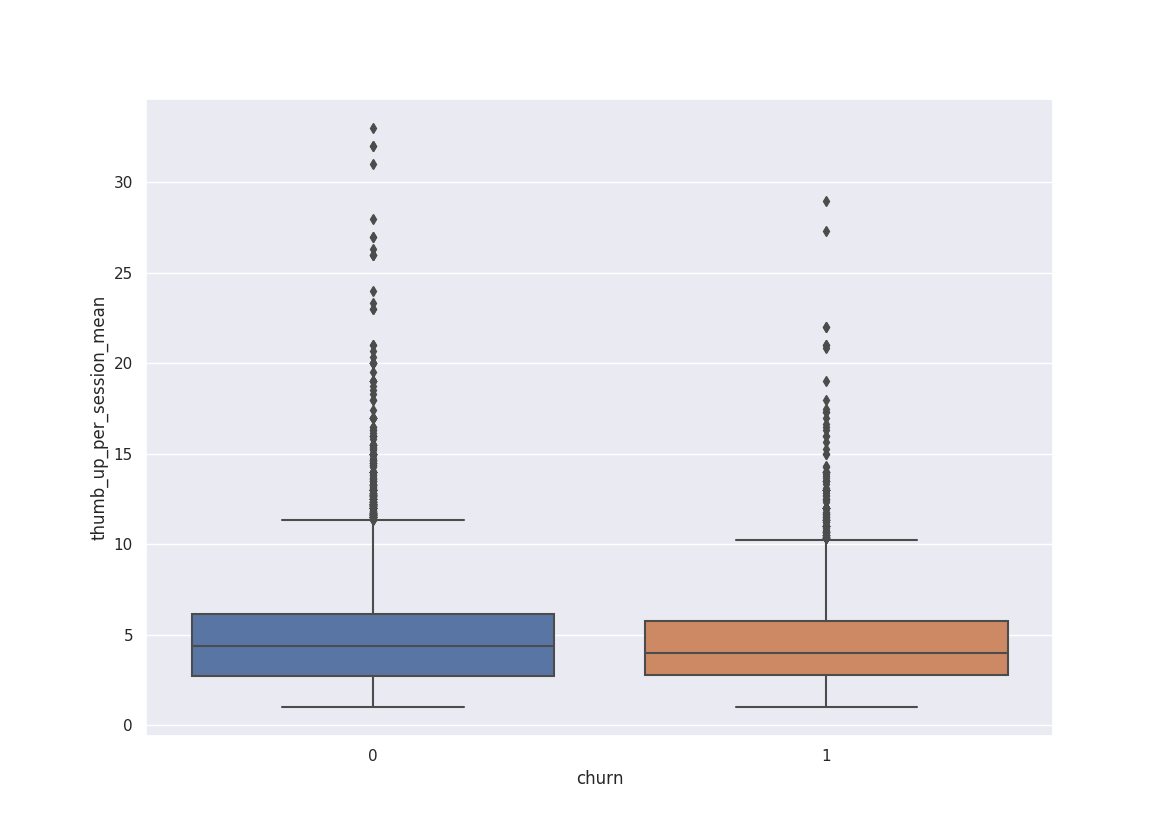

In [30]:
df_thumb_up_per_session_mean = boxplot_specific_event_per_session('Thumbs Up','thumb_up_per_session_mean')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

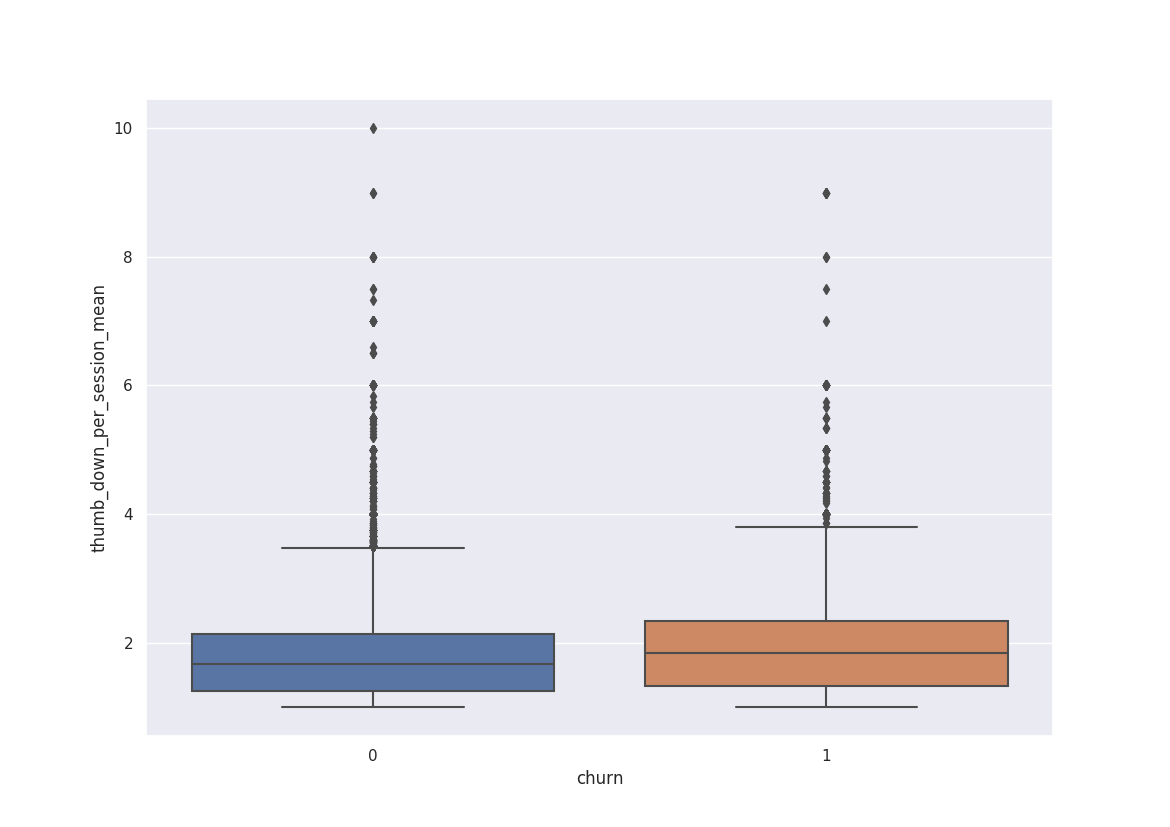

In [31]:
df_thumb_down_per_session_mean = boxplot_specific_event_per_session('Thumbs Down','thumb_down_per_session_mean')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

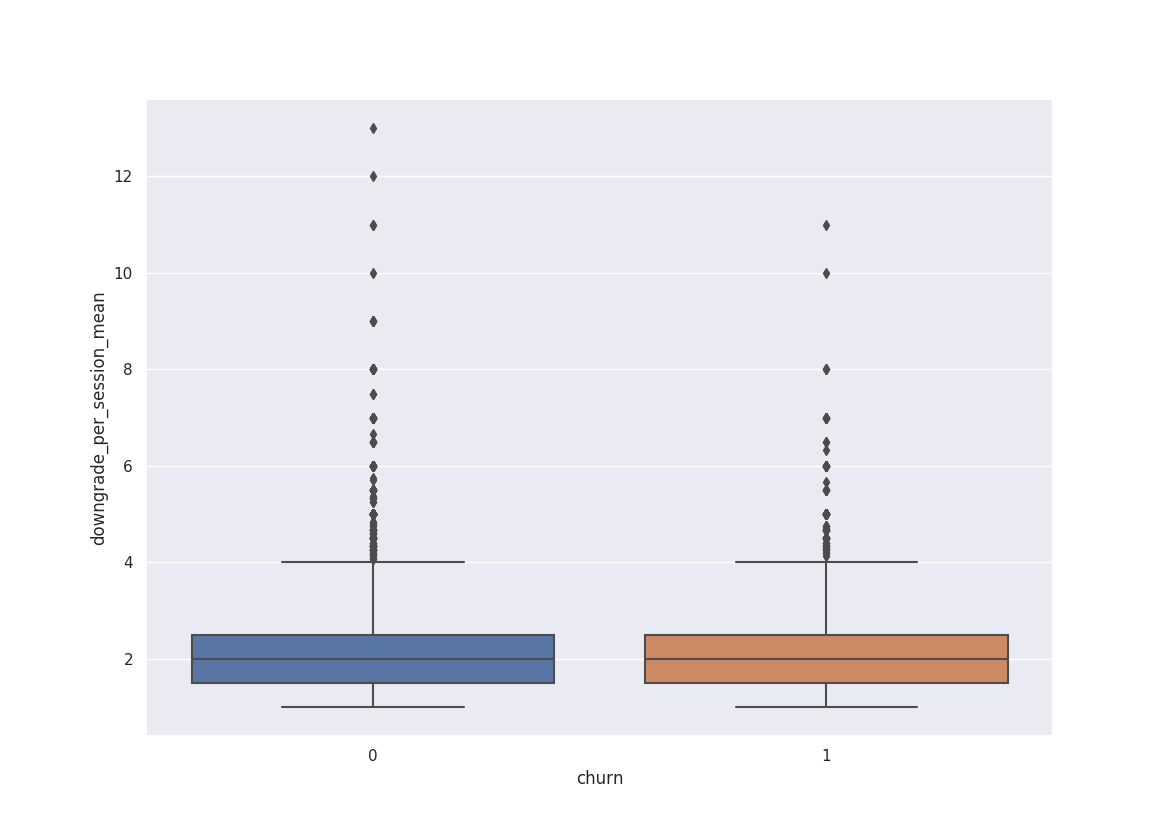

In [32]:
df_downgrade_per_session_mean = boxplot_specific_event_per_session('Downgrade','downgrade_per_session_mean')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

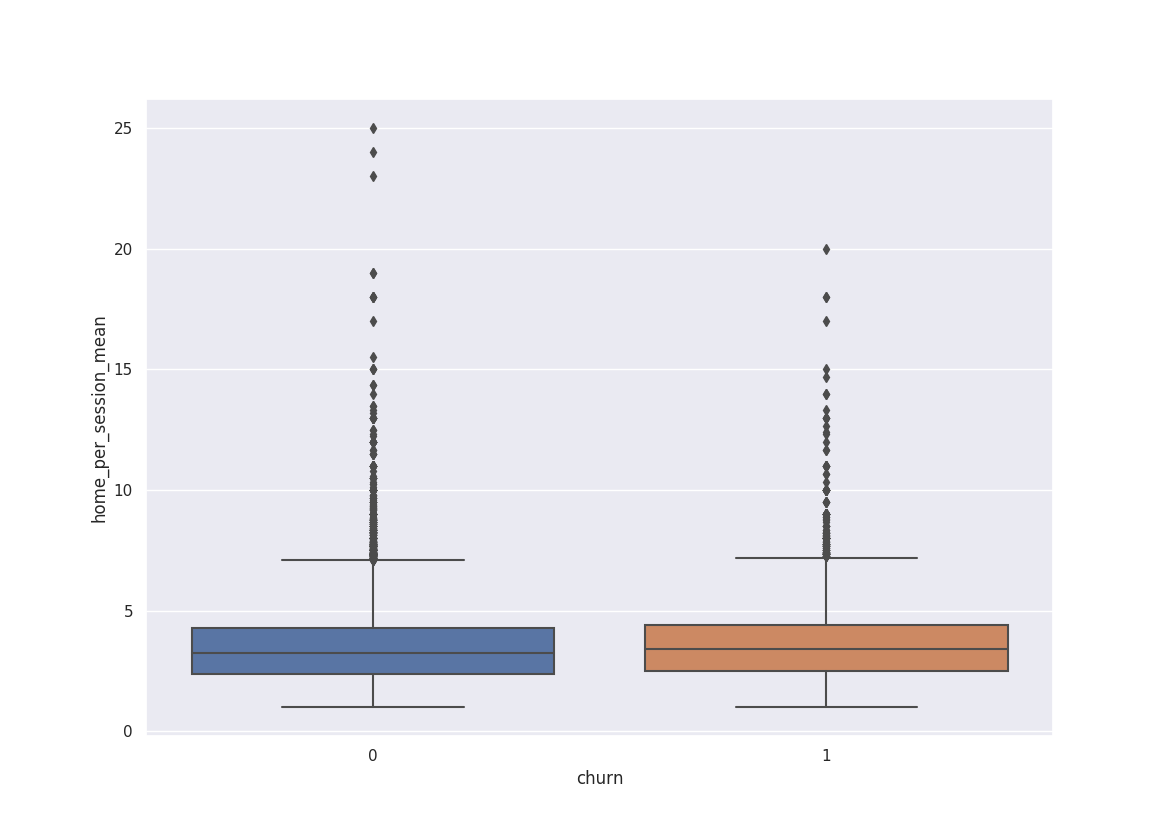

In [33]:
df_home_per_session_mean = boxplot_specific_event_per_session('Home','home_per_session_mean')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

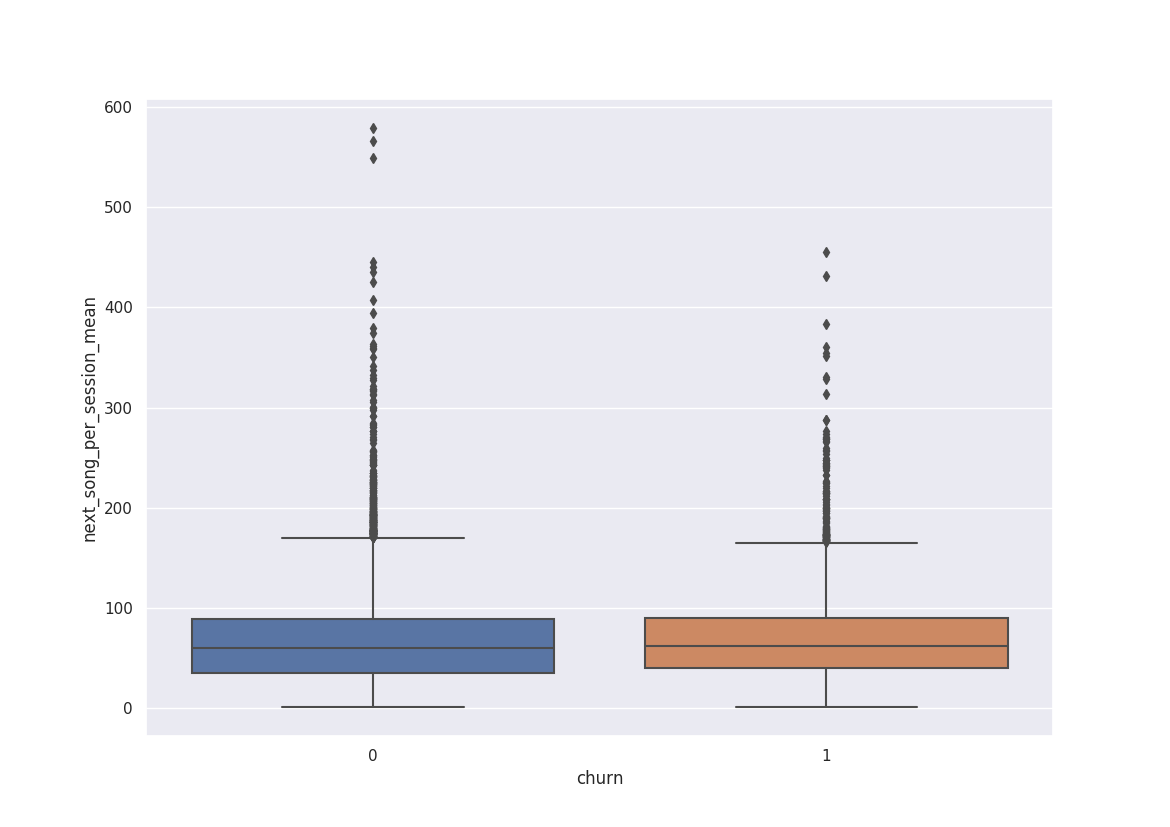

In [34]:
df_next_song_per_session_mean = boxplot_specific_event_per_session('NextSong','next_song_per_session_mean')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

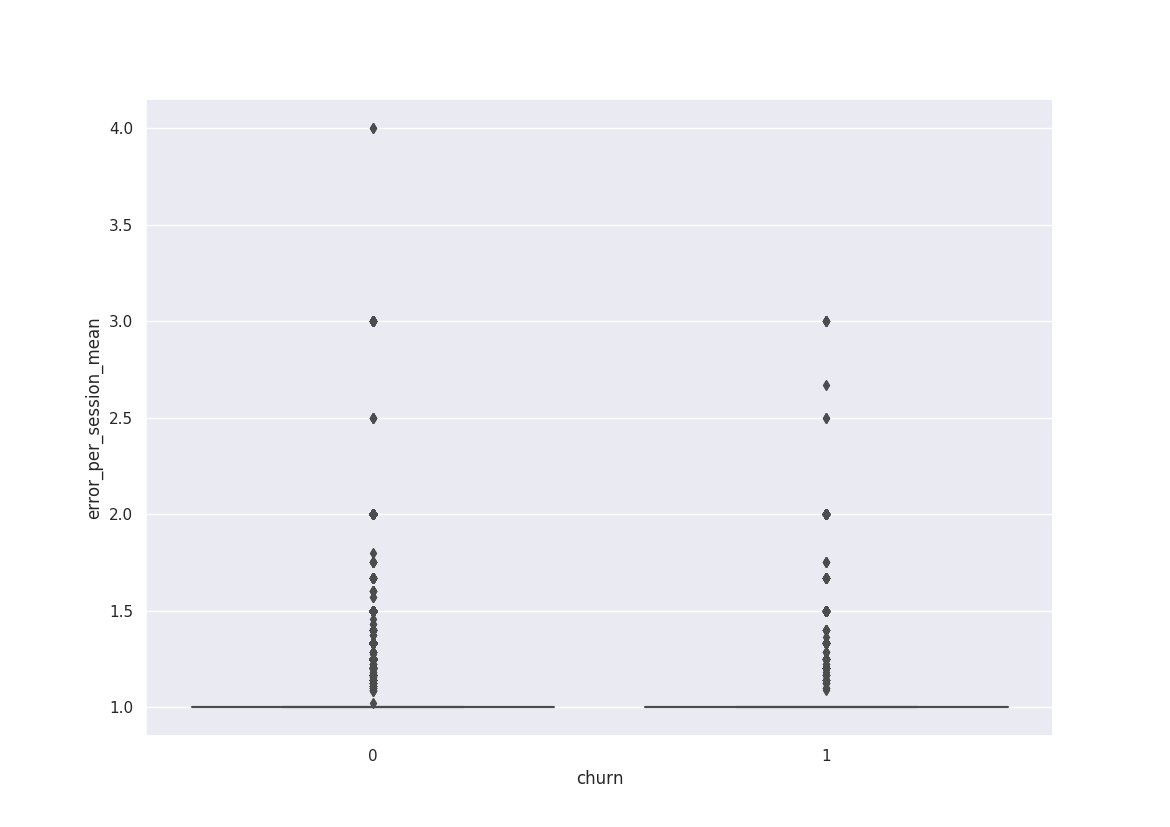

In [35]:
df_error_per_session_mean = boxplot_specific_event_per_session('Error','error_per_session_mean')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

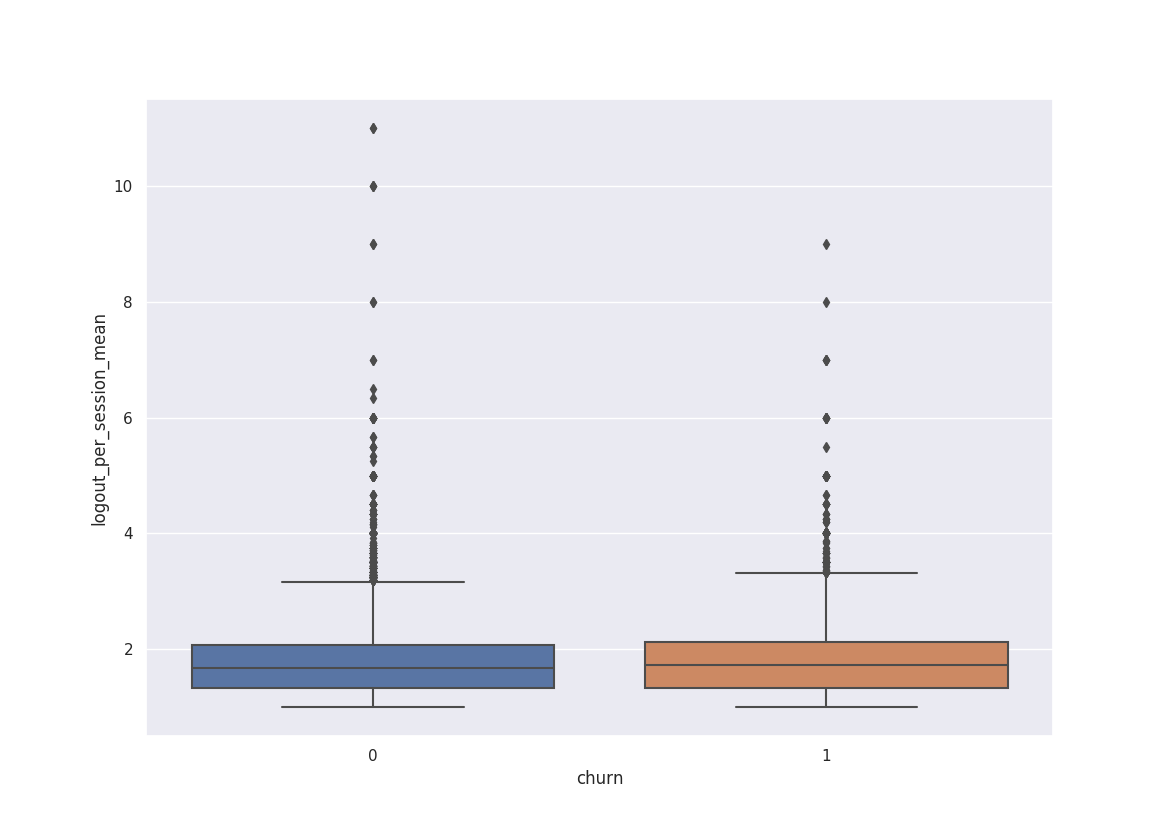

In [36]:
df_logout_per_session_mean = boxplot_specific_event_per_session('Logout','logout_per_session_mean')
%matplot plt

Like in the plot with the relative frequencies of all events the boxplots indicate a difference in behavior.

Next lets have a look at the relative frequency of usage in a month

In [37]:
df_day_churn = df.groupBy(['day_of_month','churn']).count()
total_sums = df_day_churn.groupBy('churn').sum('count').collect()
sum_churn = total_sums[0][1]
sum_not_churn = total_sums[1][1]

dfp = df_day_churn.withColumn('relativeFrequency',F.when(df_day_churn['churn']==0,df_day_churn['count']/sum_not_churn).otherwise(df_day_churn['count']/sum_churn)).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

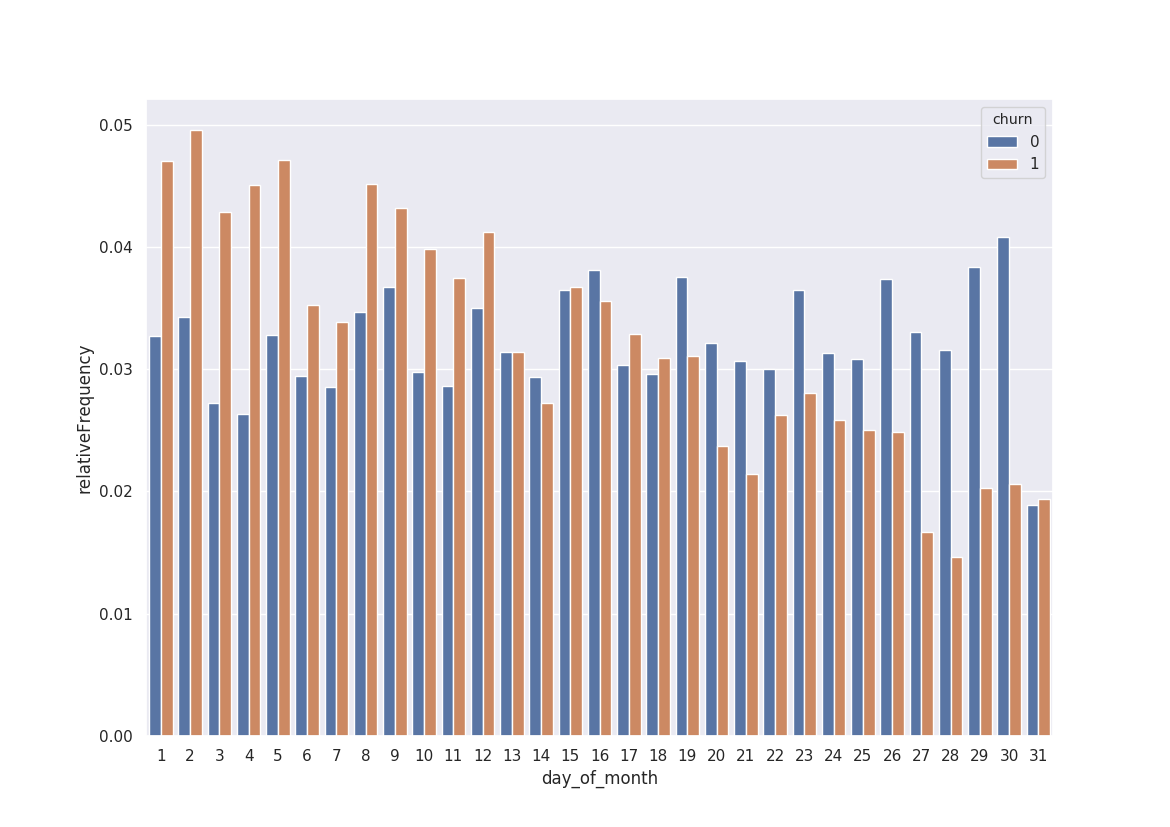

In [38]:
plt.clf()
sns.set(rc={'figure.figsize':(13.7,4.27)})
sns.barplot(x = "day_of_month", y="relativeFrequency", hue = "churn", data = dfp)
%matplot plt

First thing I recognise is that the usage during the month of the churned user is more volatile. So the variance could be higher than the not churned users.
Second the churned users use sparkify much more in the beginning of the month, the distribution is a little bit skewed.

___

Now we check the churn rates per state. First we check if a userId has a null state

In [39]:
df.select('userId','state').filter(F.col('state').isNull()).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+
|userId|state|
+------+-----+
+------+-----+

In [40]:
df_state = df.groupBy('state','churn').count()
total_sums = df_state.groupBy('churn').sum('count').collect()
sum_churn = total_sums[0][1]
sum_not_churn = total_sums[1][1]

dfp_state = df_state.withColumn('relativeFrequency',F.when(df_state['churn']==0,df_state['count']/sum_not_churn).otherwise(df_state['count']/sum_churn)).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

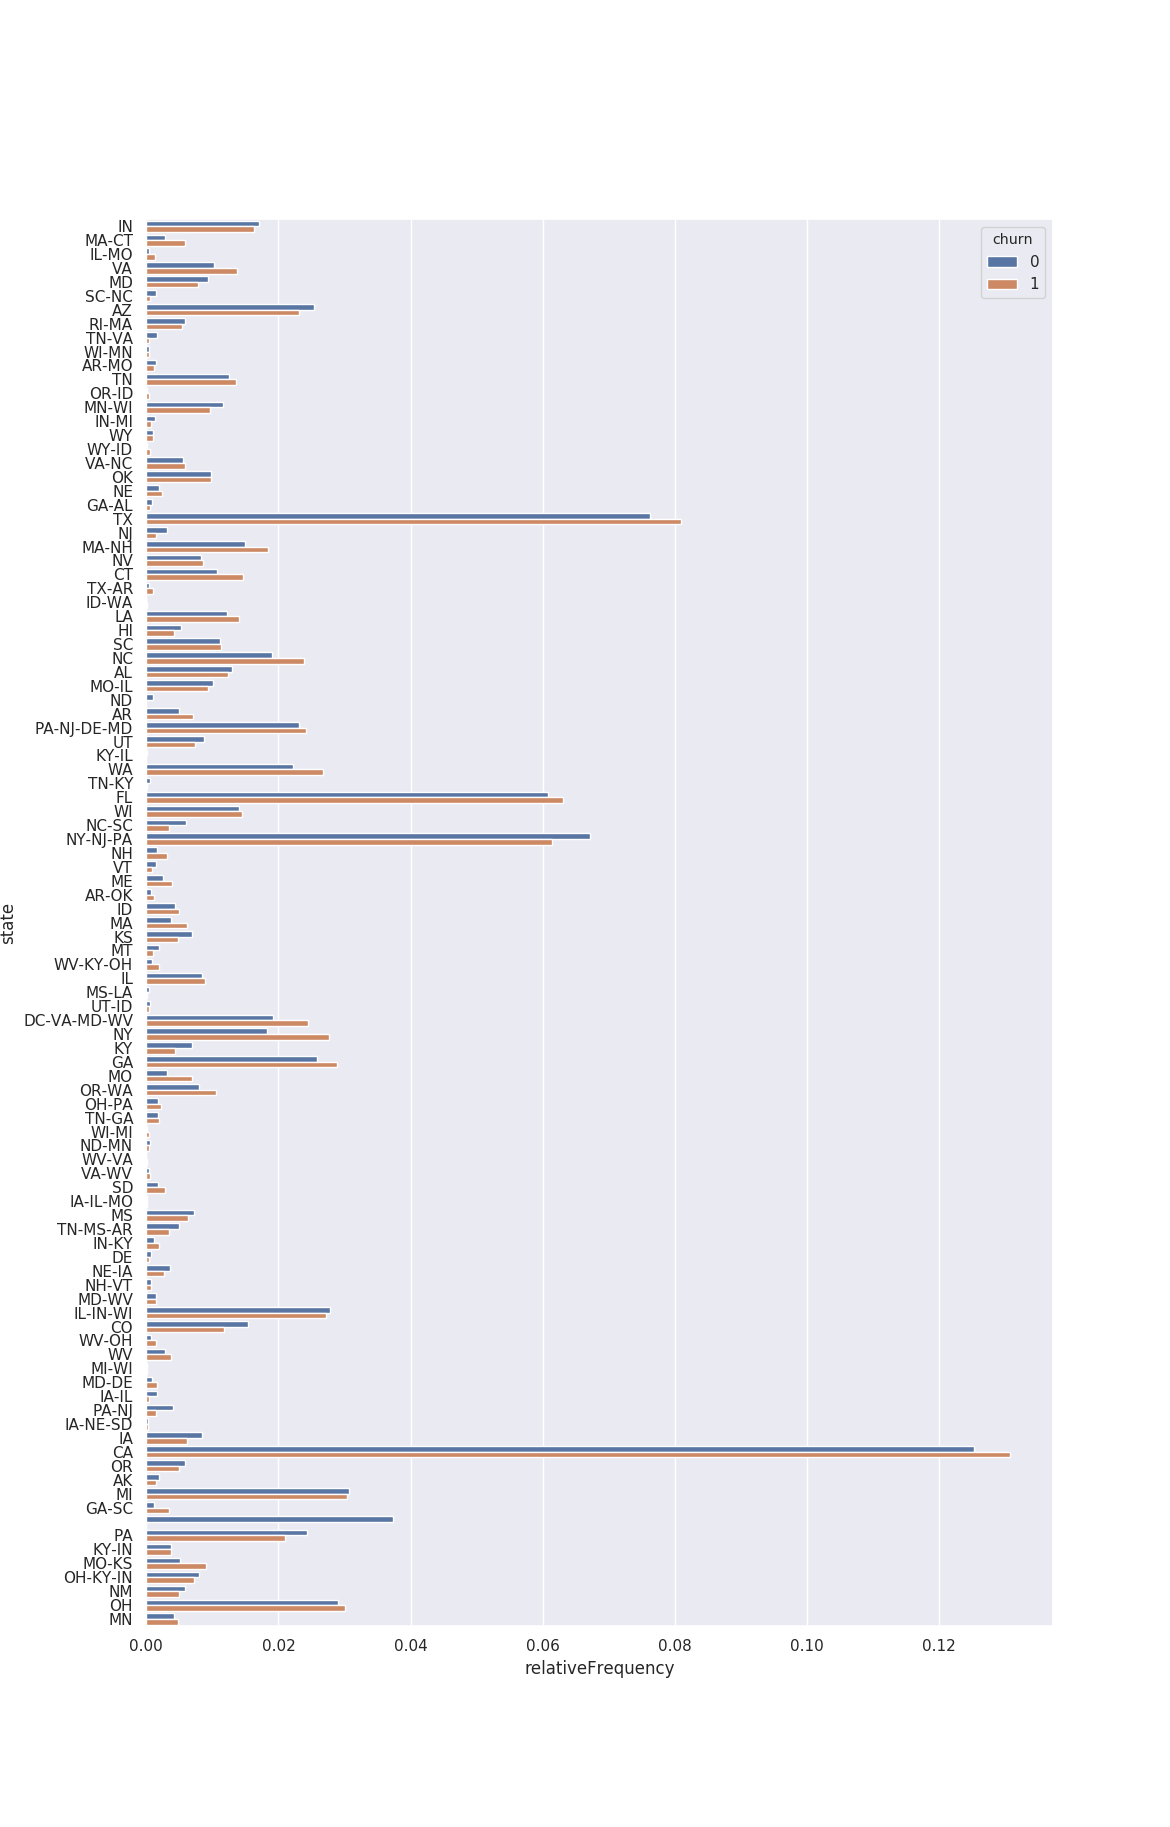

In [41]:
plt.clf()
plt.figure(figsize=(11.7,18.27))
sns.barplot(x = "relativeFrequency", y="state", hue = "churn", data = dfp_state)
%matplot plt

We can see that some states have more user which have churned. So we introduce a flag for using sparkify in a state where people churn more

In [42]:
states_more_churn = ['MA-CT','IL-MO','VA','TN','VA-NC','TX','MA-NH','CT','LA','NC','AR','PA-NJ-DE-MD','WA','FL','WI','ID','MA','IL','DC-VA-MD-WV','NY','GA','MO','OR-WA','CA','MO-KS','OH']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
@F.udf('int')
def get_churn_state(value):
    if(value in states_more_churn):
        return 1;
    else:
        return 0;


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
df = df.withColumn('churn_state',get_churn_state('state'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

___

Lastly we will check to total duration from first event to last event:

In [45]:
df_min_ts = df.groupBy('userId','churn').min('ts')
df_max_ts = df.groupBy('userId').max('ts')

df_min_max_ts = df_min_ts.join(df_max_ts,['userId'],'outer')

# calculate the duration and convert in days
df_duration = df_min_max_ts.withColumn('duration',(F.col('max(ts)')-F.col('min(ts)'))/1000/60/60/24)

df_duration = df_duration.drop('min(ts)','max(ts)')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
dfp = df_duration.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

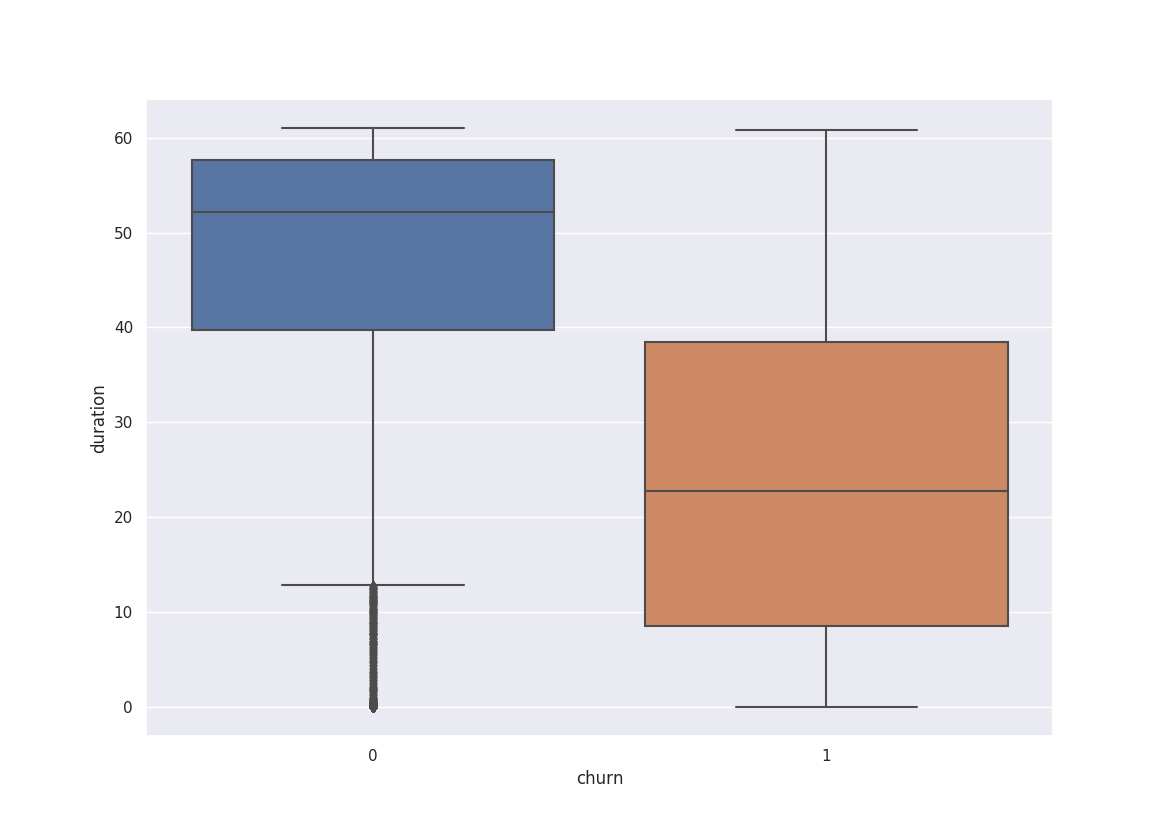

In [47]:
plt.figure(figsize=(11.7,8.27))
plot_boxplot('duration',dfp)
%matplot plt

## Feature Engineering
We had a deeper look in some of the aggregations of the event data. Now lets build the features to use for our classifier

We start with a plain dataframe with unique userIds if they have churned

In [48]:
df_features = df.select('userId','churn').dropDuplicates(['userId'])
print(f"Total users: {df_features.count()}")
print(f"Churned users: {df_features.filter(F.col('churn')==1).count()}")
print(f"Not churned users: {df_features.filter(F.col('churn')==0).count()}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total users: 22278
Churned users: 5003
Not churned users: 17275

We add the gender as feature and will use one hot encoding for male, because there were only 2 genders in the dataset

In [49]:
@F.udf('int')
def is_male(value):
    return 1 if value == 'M' else 0

df_male = df.select('userId',is_male('gender').alias('is_male')).dropDuplicates(['userId'])
df_features = df_features.join(df_male,['userId'],'outer')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Also we add the level with one hot encoding for paid

In [50]:
@F.udf('int')
def is_paying(value):
    return 1 if value == 'paid' else 0

df_level = df.select('userId',is_paying('level').alias('is_paying')).dropDuplicates(['userId'])   
df_features = df_features.join(df_level,['userId'],'outer')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now lets add all occurences per session. Luckily we can use the calculations from above:

In [51]:
df_features = df_features.join(df_userId_sessionId_count.drop('churn'),['userId'],'outer')
df_features = df_features.join(df_song_churn.drop('churn'),['userId'],'outer')
df_features = df_features.join(df_adverts_per_session_mean.drop('churn'),['userId'],'outer')
df_features = df_features.join(df_thumb_up_per_session_mean.drop('churn'),['userId'],'outer')
df_features = df_features.join(df_thumb_down_per_session_mean.drop('churn'),['userId'],'outer')
df_features = df_features.join(df_downgrade_per_session_mean.drop('churn'),['userId'],'outer')
df_features = df_features.join(df_home_per_session_mean.drop('churn'),['userId'],'outer')
df_features = df_features.join(df_next_song_per_session_mean.drop('churn'),['userId'],'outer')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
df_features = df_features.join(df_error_per_session_mean.drop('churn'),['userId'],'outer')
df_features = df_features.join(df_logout_per_session_mean.drop('churn'),['userId'],'outer')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Probably not all users used all of these pages. Therefore the outer join will generate nulls for the missing values.
We will fill the missing values with 0 at the end.

Now we will calculate the variance and skewness for the usage over the month and add them as features

In [53]:
df_user_day = df.select('userId','day_of_month').groupBy('userId','day_of_month').count().sort(['userId','day_of_month'])
df_day_variance = df_user_day.groupBy('userId').agg(F.variance('count').alias('usage_variance')).replace(float('nan'), 0)
df_day_skewness = df_user_day.groupBy('userId').agg(F.skewness('count').alias('usage_skewness')).replace(float('nan'), 0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
df_features = df_features.join(df_day_variance,['userId'],'outer')
df_features = df_features.join(df_day_skewness,['userId'],'outer')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Next we add the flag if the user uses sparkify in a state where more users churn

In [55]:
df_churn_state = df.select('churn_state','userId').dropDuplicates(['userId'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
df_features = df_features.join(df_churn_state,['userId'],'outer')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Lastly add the duration of users as a feature

In [57]:
df_features =df_features.join(df_duration.drop('churn'),['userId'],'outer')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
df_features = df_features.fillna(0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Lets have a look at the schema to check the datatypes:

In [59]:
df_features.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- is_male: integer (nullable = true)
 |-- is_paying: integer (nullable = true)
 |-- events_per_session_mean: double (nullable = false)
 |-- songs_per_session_mean: double (nullable = false)
 |-- adverts_per_session_mean: double (nullable = false)
 |-- thumb_up_per_session_mean: double (nullable = false)
 |-- thumb_down_per_session_mean: double (nullable = false)
 |-- downgrade_per_session_mean: double (nullable = false)
 |-- home_per_session_mean: double (nullable = false)
 |-- next_song_per_session_mean: double (nullable = false)
 |-- error_per_session_mean: double (nullable = false)
 |-- logout_per_session_mean: double (nullable = false)
 |-- usage_variance: double (nullable = false)
 |-- usage_skewness: double (nullable = false)
 |-- churn_state: integer (nullable = true)
 |-- duration: double (nullable = false)

We have far less users who churned, so we will use the F1 Score to evaluate the models during Cross Validation.

___

## Modeling

We have now all of the features in a neat dataframe and we can start with finding a model to predict a user to churn.

First we have to use spark's VectorAssembler to transform the feature rows in sparse vectors:

In [60]:
input_cols = df_features.columns
input_cols.remove('userId')
input_cols.remove('churn')
vecAssembler = VectorAssembler(inputCols = input_cols, outputCol = "features")
df_final = vecAssembler.transform(df_features)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Then we will use the StandardScaler to reduce bad prediction because of different scaled values

In [61]:
stdScaler = StandardScaler(inputCol="features", outputCol="stdFeatures")
stdScalerModel = stdScaler.fit(df_final)
df_final = stdScalerModel.transform(df_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

After that we split the data in a training and validation set

In [62]:
ml_data = df_final.select(df_final.churn.alias('label'),df_final.stdFeatures.alias('features'))
                          
train, validation = ml_data.randomSplit([0.9, 0.1], seed=4)
train = train.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Lets define helper function for training different models with different classifer algorithm and for result validation

In [63]:
def train_model(classifier):
    print("Train simple classifier")
    model = classifier.fit(train)
    print(f"Training done")
    return model


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [64]:
def train_model_crossval(classifier, paramGrid):
    # MulticlassClassificationEvaluator default is f1
    crossVal = CrossValidator(estimator=classifier,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=3)
    print("Train with Cross Validation")
    model = crossVal.fit(train)
    print(f"Average accuracy for each param combination:\n{model.avgMetrics}")
    
    return model

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
def check_validation_confmatrix(model):
    results = model.transform(validation)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    accuracy = evaluator.evaluate(results, {evaluator.metricName: "accuracy"})
    f1score = evaluator.evaluate(results, {evaluator.metricName: "f1"})
    label_actual = results.select("label").rdd.flatMap(lambda x: x).collect()
    label_prediction = results.select("prediction").rdd.flatMap(lambda x: x).collect()
    conf_matrix = confusion_matrix(label_actual, label_prediction)
    plt.clf()
    sns.heatmap(pd.DataFrame(conf_matrix), annot=True,cbar=False)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    
    return accuracy, f1score


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
def print_accuracy_f1(accuracy, f1score):
    print('Accuracy and F1 Score Metrics:')
    print(f'Accuracy: {accuracy}')
    print(f'F1 Score: {f1score}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Logistic Regression
Lets start with the logistic regression:

In [67]:
lr =  LogisticRegression()

# lrParamGrid = ParamGridBuilder() \
#     .addGrid(lr.elasticNetParam,[0.3, 0.6]) \
#     .addGrid(lr.regParam,[0.0, 0.5]) \
#     .build()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
lrModel = train_model(lr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-68:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 785



Train simple classifier
Training done

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

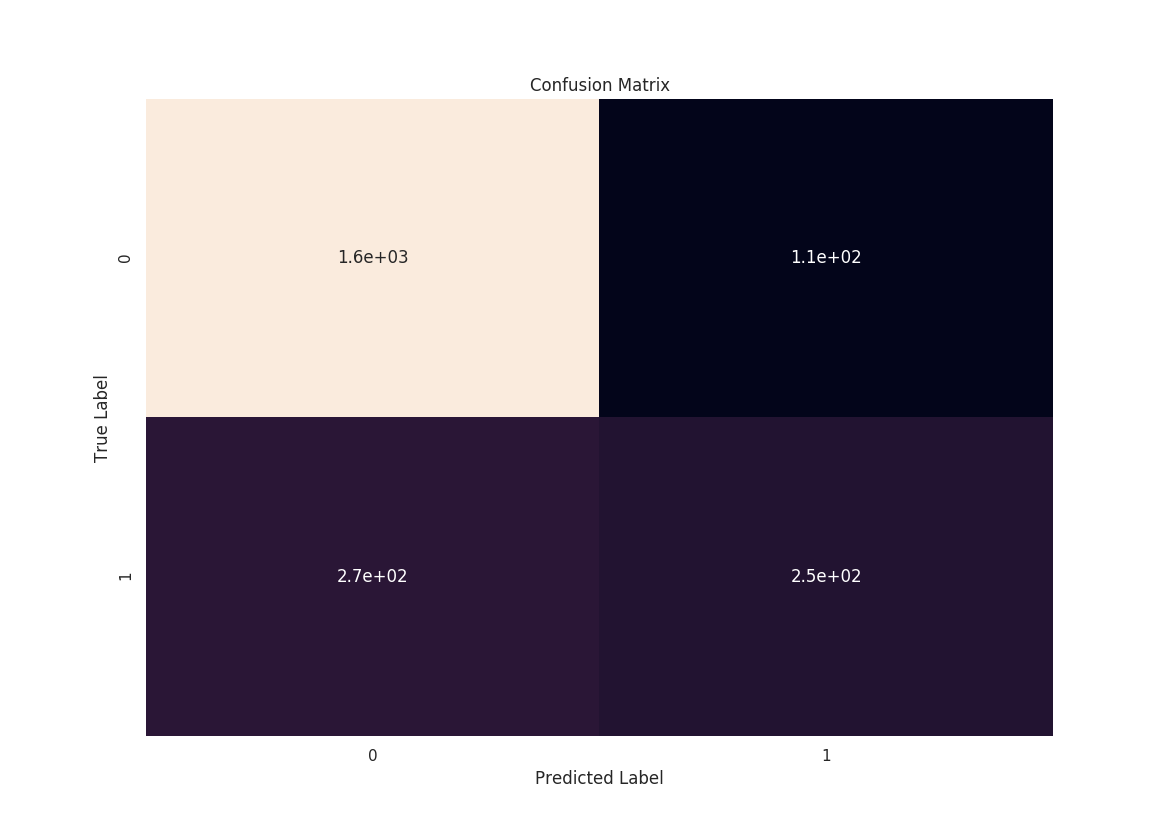

In [69]:
accuracy, f1score = check_validation_confmatrix(lrModel)
%matplot plt

In [70]:
print_accuracy_f1(accuracy, f1score)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy and F1 Score Metrics:
Accuracy: 0.8277576853526221
F1 Score: 0.821336115628103

#### RandomForest

In [71]:
rf =  RandomForestClassifier()
# print(rf.explainParams())


# rfParamGrid = ParamGridBuilder() \
#     .addGrid(rf.maxDepth,[5, 10]) \
#     .addGrid(rf.impurity,['gini', 'entropy']) \
#     .addGrid(rf.maxBins,[32, 48]) \
#     .build()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
rfModel = train_model(rf)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train simple classifier
Training done

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

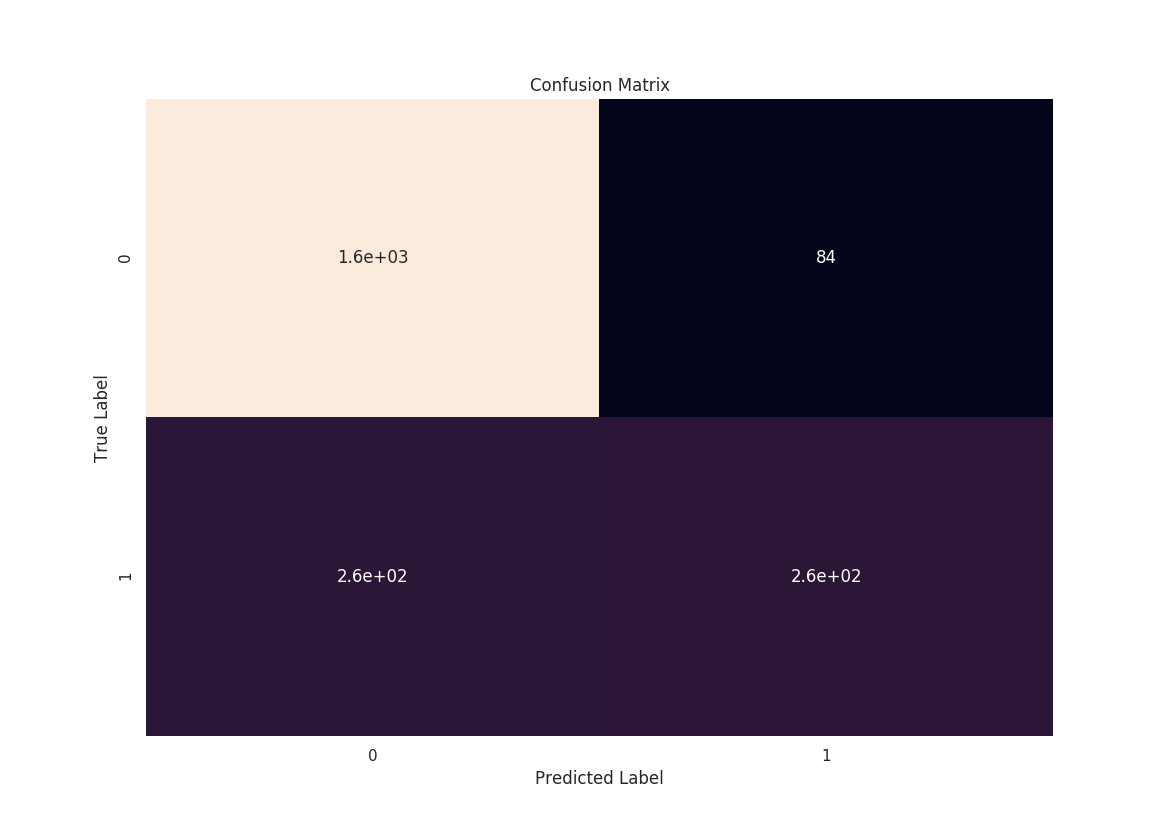

In [73]:
accuracy, f1score = check_validation_confmatrix(rfModel)
%matplot plt   

In [74]:
print_accuracy_f1(accuracy, f1score)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy and F1 Score Metrics:
Accuracy: 0.8462929475587704
F1 Score: 0.8347053545596823

#### GradientBoostedTrees

In [75]:
gbt =  GBTClassifier()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
gbtModel = train_model(gbt)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-76:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 4749



Train simple classifier
Training done

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

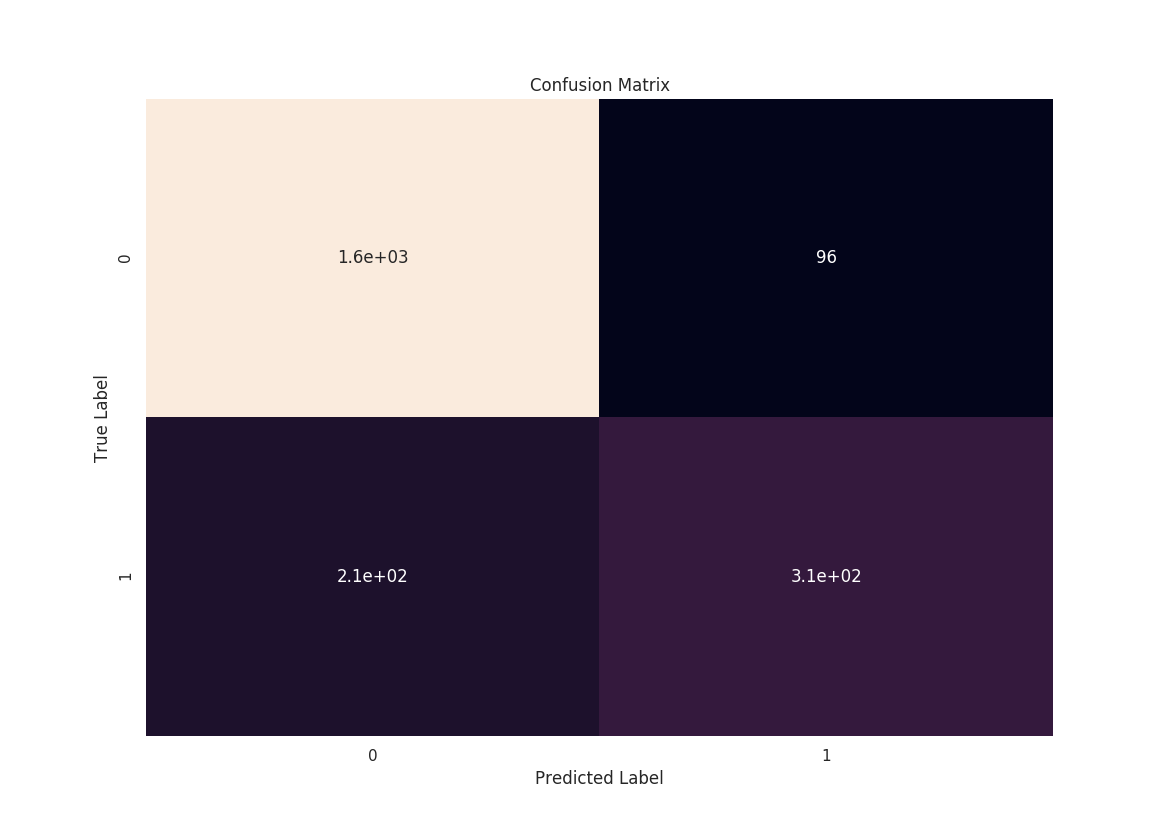

In [77]:
accuracy, f1score = check_validation_confmatrix(gbtModel)
%matplot plt

In [78]:
print_accuracy_f1(accuracy, f1score)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy and F1 Score Metrics:
Accuracy: 0.8657323688969258
F1 Score: 0.8599681106514127

In [79]:
gbtParamGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .addGrid(gbt.stepSize,[0.1,0.5]) \
    .build()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
gbtCVModel = train_model_crossval(gbt,gbtParamGrid)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-80:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 8909



Train with Cross Validation
Average accuracy for each param combination:
[0.8588883654696753, 0.8592287059309462, 0.8370924868895504, 0.8352888961652989]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

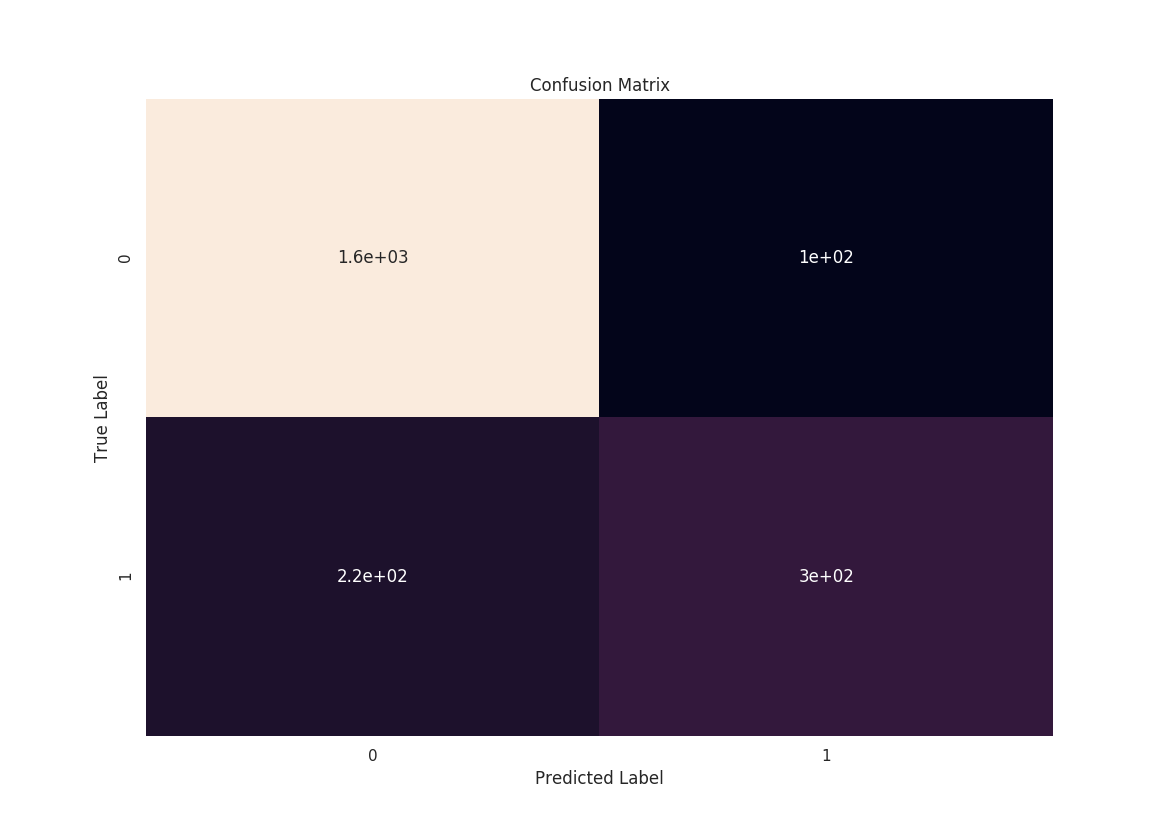

In [81]:
accuracy, f1score = check_validation_confmatrix(gbtModel)
%matplot plt

In [82]:
print_accuracy_f1(accuracy, f1score)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy and F1 Score Metrics:
Accuracy: 0.8603074141048824
F1 Score: 0.8577913882736197